## Early exiting with prototypes

In this notebook, we provide examples of **early exiting with prototypes** for OPT and BERT language models.

Early exiting is based on a **prototype margin rule**. For each class $c \in \{0,1\}$ and each layer $\ell$, we construct a class prototype by averaging training representations from that class:

$$
\mu_c^{(\ell)} \;=\; \frac{1}{|\mathcal{D}_c|}\sum_{(x,y)\in\mathcal{D}_c} h^{(\ell)}(x),
\qquad
\mu_c^{(\ell)}\in\mathbb{R}^d.
$$

At inference time, for a new input $x$, we compute its similarity to both class prototypes at layer $\ell$:

$$
s_c^{(\ell)}(x)=\tilde h^{(\ell)}(x)^\top \tilde \mu_c^{(\ell)},
$$

where both representations are $\ell_2$-normalized:

$$
\tilde h^{(\ell)}(x) \;=\; \frac{h^{(\ell)}(x)}{\|h^{(\ell)}(x)\|_2},
\qquad
\tilde \mu_c^{(\ell)} \;=\; \frac{\mu_c^{(\ell)}}{\|\mu_c^{(\ell)}\|_2}.
$$

Let $s^{(\ell)}_{(1)} \ge s^{(\ell)}_{(2)}$ denote the largest and second-largest values among
$\{s_c^{(\ell)}(x)\,:\, c\in\{0,1\}\}$.
We define the **margin** at layer $\ell$ as:

$$
m^{(\ell)}(x) \;=\; s^{(\ell)}_{(1)} - s^{(\ell)}_{(2)}.
$$

To enable early exiting, we stop the forward pass at the **first** layer $\hat{\ell}$ such that:

$$
m^{(\hat{\ell})}(x) \;\ge\; \delta,
$$

where $\delta > 0$ is a fixed margin threshold controlling the efficiency–accuracy trade-off.

If no layer satisfies this condition, inference proceeds through all $L$ layers and the prediction from the final layer is used.


## Prototype-based Early Exit for OPT (last non-padding token)

In [ ]:
# !pip -q install transformers torch pandas scikit-learn
import os, random, numpy as np, pandas as pd, torch
from typing import List, Tuple, Dict
from sklearn.metrics import f1_score, accuracy_score
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
import matplotlib as mpl
import matplotlib.pyplot as plt

MAX_SAMPLES_PER_CLASS_FOR_PROTOS = 500
BATCH_SIZE  = 8
MAX_LENGTH  = 256
USE_FP16    = False

FIXED_THRESHOLD = 0.65 # confidence threshold, optional, in the experiments from the paper we do not use it

TEXT_COL  = "sentence"
LABEL_COL = "label"

def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def normalize_labels(series: pd.Series) -> pd.Series:
    mapping = {"hate":1, "non-hate":0, "nonhate":0, "non_hate":0, "neutral":0}
    def _to_int(x):
        if isinstance(x, str):
            xl = x.strip().lower()
            if xl in mapping: return mapping[xl]
            try: return int(x)
            except: raise ValueError(f"Unrecognized label: {x}")
        if isinstance(x, (int, np.integer)):
            if x in (0,1): return int(x)
        raise ValueError(f"Unsupported label value: {x}")
    return series.apply(_to_int)

class TextDS(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tok, max_len):
        self.texts, self.labels, self.tok, self.max_len = texts, labels, tok, max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(
            str(self.texts[i]), truncation=True, padding="max_length",
            max_length=self.max_len, return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i]).long()
        return item

def make_loader(texts, labels, tok, max_len, bs, shuffle=False):
    return torch.utils.data.DataLoader(TextDS(texts, labels, tok, max_len), batch_size=bs, shuffle=shuffle)

@torch.no_grad()
def collect_layerwise_lasttok(model, loader, device) -> Tuple[List[np.ndarray], List[int]]:
    """
    For OPT/GPT-like models: use the last non-padding token representation.
    """
    model.eval()
    feats_per_layer = None
    all_labels = []
    for batch in loader:
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        all_labels.extend(batch["labels"].tolist())
        out = model(input_ids=ids, attention_mask=att, output_hidden_states=True)
        hs = out.hidden_states[1:] # skip embeddings

        # find last non-padding token index per sample
        last_idxs = att.sum(dim=1) - 1  # (batch,)
        layer_reps = []
        for h in hs:
            # h: (batch, seq, dim)
            reps = []
            for bi, idx in enumerate(last_idxs):
                reps.append(h[bi, idx, :].detach().unsqueeze(0))
            reps = torch.cat(reps, dim=0)  # (batch, dim)
            layer_reps.append(reps)

        cls_np = [t.float().cpu().numpy() for t in layer_reps]
        if feats_per_layer is None: feats_per_layer = [[] for _ in range(len(cls_np))]
        for li, arr in enumerate(cls_np): feats_per_layer[li].append(arr)

    feats_per_layer = [np.concatenate(chunks, axis=0) for chunks in feats_per_layer]
    return feats_per_layer, all_labels

def l2_normalize(x: np.ndarray, axis: int = -1, eps: float = 1e-8) -> np.ndarray:
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / (n + eps)

def build_class_means(feats_per_layer: List[np.ndarray], labels: List[int]) -> Dict[int, List[np.ndarray]]:
    y = np.array(labels)
    class_means = {}
    for c in (0,1):
        idx = (y == c)
        means = []
        for feats in feats_per_layer:
            # normalize each vector first
            feats_c = l2_normalize(feats[idx], axis=1)
            # average and re-normalize the mean vector
            mu = feats_c.mean(axis=0)
            mu = l2_normalize(mu[None, :], axis=1)[0]
            means.append(mu)
        class_means[c] = means
    return class_means

def cosine_scores(x: np.ndarray, p0: np.ndarray, p1: np.ndarray):
    s0 = (x @ p0); s1 = (x @ p1)
    scores = np.stack([s0, s1], axis=1)
    conf = scores.max(axis=1)
    pred = scores.argmax(axis=1)
    gap  = np.sort(scores, axis=1)[:, -1] - np.sort(scores, axis=1)[:, -2]
    return conf, pred, gap

def early_exit_predict(test_feats_per_layer, class_means, threshold, min_gap):
    L = len(test_feats_per_layer)
    N = test_feats_per_layer[0].shape[0]
    preds = np.zeros(N, dtype=int)
    exit_layers = np.full(N, L-1)
    decided = np.zeros(N, bool)
    feats_norm = [l2_normalize(f) for f in test_feats_per_layer]
    for li in range(L):
        f = feats_norm[li]
        p0, p1 = class_means[0][li], class_means[1][li]
        conf, pred, gap = cosine_scores(f, p0, p1)
        to_exit = (~decided) & (gap >= min_gap)
        preds[to_exit] = pred[to_exit]
        exit_layers[to_exit] = li
        decided[to_exit] = True
    rem = ~decided
    if rem.any():
        f = feats_norm[-1]; p0, p1 = class_means[0][-1], class_means[1][-1]
        _, pred, _ = cosine_scores(f, p0, p1)
        preds[rem] = pred[rem]
    return preds, exit_layers


def compute_metrics(y_true, preds, exit_layers, num_layers):
    acc = accuracy_score(y_true, preds)
    f1m = f1_score(y_true, preds, average="macro")
    avg_exit = exit_layers.mean() + 1
    Nm = np.array([(exit_layers == m).sum() for m in range(num_layers)])
    full_cost = num_layers * Nm.sum()
    actual_cost = sum((m+1) * Nm[m] for m in range(num_layers))
    speedup = full_cost / actual_cost if actual_cost > 0 else 1.0
    early_mask = (exit_layers < (num_layers-1))
    coverage = early_mask.mean()
    early_prec = (preds[early_mask] == y_true[early_mask]).mean() if early_mask.any() else np.nan
    return {"acc":acc, "f1m":f1m, "avg_exit":avg_exit,
            "speedup":speedup, "coverage":coverage, "early_prec":early_prec,
            "exit_hist":Nm}

def run_dataset(dataset, seeds, gap_values):
    results = {g: [] for g in gap_values}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_csv(f"{dataset}_train.csv")
    test_df  = pd.read_csv(f"{dataset}_test.csv")
    for df in [train_df, test_df]:
        df.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)
        df["label"] = normalize_labels(df[LABEL_COL])
        df["text"]  = df[TEXT_COL].astype(str)

    for seed in seeds:
        set_seed(seed)
        MODEL_NAME = f"iproskurina/opt-125m-{dataset}-s{seed}"
        tok = AutoTokenizer.from_pretrained("facebook/opt-125m", use_fast=True)
        model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)
        if USE_FP16 and device.type == "cuda":
            model = model.half()
        model.to(device)

        tr0 = train_df[train_df["label"] == 0].head(MAX_SAMPLES_PER_CLASS_FOR_PROTOS)
        tr1 = train_df[train_df["label"] == 1].head(MAX_SAMPLES_PER_CLASS_FOR_PROTOS)
        protos = pd.concat([tr0, tr1])

        proto_loader = make_loader(protos["text"].tolist(), protos["label"].tolist(), tok, MAX_LENGTH, BATCH_SIZE)
        test_loader  = make_loader(test_df["text"].tolist(),  test_df["label"].tolist(),  tok, MAX_LENGTH, BATCH_SIZE)

        proto_feats, proto_labels = collect_layerwise_lasttok(model, proto_loader, device)
        class_means = build_class_means(proto_feats, proto_labels)
        test_feats, test_labels = collect_layerwise_lasttok(model, test_loader, device)
        y_true = np.array(test_labels)
        num_layers = len(test_feats)

        for g in gap_values:
            preds, exit_layers = early_exit_predict(test_feats, class_means, FIXED_THRESHOLD, g)
            m = compute_metrics(y_true, preds, exit_layers, num_layers)
            results[g].append(m)

        del model; torch.cuda.empty_cache()

    agg = {}
    for g in gap_values:
        metrics = results[g]
        agg[g] = {
            "mean": {k: np.nanmean([m[k] for m in metrics], axis=0) for k in metrics[0].keys()},
            "std":  {k: np.nanstd([m[k] for m in metrics], axis=0) for k in metrics[0].keys()},
        }
    return agg


def print_results_table(dataset, agg, gap_values):
    print(f"\n=== {dataset} averaged across seeds (OPT last-token) ===")
    print("gap\tAcc±std\tF1±std\tSpeedup±std\tAvgExit±std\tCoverage±std\tEarlyPrec±std")
    for g in gap_values:
        a = agg[g]["mean"]
        s = agg[g]["std"]
        print(f"{g:.3f}\t"
              f"{a['acc']:.3f}±{s['acc']:.3f}\t"
              f"{a['f1m']:.3f}±{s['f1m']:.3f}\t"
              f"{a['speedup']:.2f}±{s['speedup']:.2f}\t"
              f"{a['avg_exit']:.2f}±{s['avg_exit']:.2f}\t"
              f"{a['coverage']:.2f}±{s['coverage']:.2f}\t"
              f"{a['early_prec']:.2f}±{s['early_prec']:.2f}")

GAP_VALUES = [0, 0.01, 0.025, 0.05, 0.075, 0.9, 0.1]
datasets = ["hatexplain","olid","ihc","sbic"]
seeds = list(range(10))
aggs = dict()
for dataset in datasets:
    agg = run_dataset(dataset, seeds, GAP_VALUES)
    print_results_table(dataset, agg, GAP_VALUES)
    aggs[dataset] = agg


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/tmp/ipython-input-806546678.py:230: RuntimeWarning: Mean of empty slice
  "mean": {k: np.nanmean([m[k] for m in metrics], axis=0) for k in metrics[0].keys()},
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



=== hatexplain averaged across seeds (OPT last-token) ===
gap	Acc±std	F1±std	Speedup±std	AvgExit±std	Coverage±std	EarlyPrec±std
0.000	0.534±0.002	0.533±0.002	12.00±0.00	1.00±0.00	1.00±0.00	0.53±0.00
0.010	0.610±0.006	0.609±0.006	3.68±0.16	3.27±0.14	1.00±0.00	0.61±0.01
0.025	0.746±0.006	0.743±0.005	1.65±0.04	7.28±0.19	0.95±0.01	0.75±0.00
0.050	0.780±0.005	0.776±0.005	1.28±0.03	9.35±0.19	0.81±0.02	0.82±0.00
0.075	0.784±0.005	0.779±0.005	1.17±0.02	10.23±0.19	0.68±0.03	0.86±0.01
0.900	0.783±0.005	0.779±0.005	1.00±0.00	12.00±0.00	0.00±0.00	nan±nan
0.100	0.783±0.005	0.779±0.005	1.11±0.02	10.83±0.17	0.56±0.04	0.89±0.01


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/tmp/ipython-input-806546678.py:230: RuntimeWarning: Mean of empty slice
  "mean": {k: np.nanmean([m[k] for m in metrics], axis=0) for k in metrics[0].keys()},
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



=== olid averaged across seeds (OPT last-token) ===
gap	Acc±std	F1±std	Speedup±std	AvgExit±std	Coverage±std	EarlyPrec±std
0.000	0.594±0.002	0.544±0.002	12.00±0.00	1.00±0.00	1.00±0.00	0.59±0.00
0.010	0.709±0.003	0.617±0.003	4.13±0.07	2.91±0.05	1.00±0.00	0.71±0.00
0.025	0.765±0.003	0.673±0.005	2.93±0.04	4.10±0.06	0.99±0.01	0.77±0.00
0.050	0.818±0.009	0.757±0.014	1.62±0.04	7.42±0.18	0.94±0.01	0.83±0.01
0.075	0.842±0.009	0.803±0.011	1.36±0.02	8.86±0.14	0.87±0.02	0.88±0.01
0.900	0.846±0.007	0.811±0.009	1.00±0.00	12.00±0.00	0.00±0.00	nan±nan
0.100	0.846±0.007	0.811±0.009	1.24±0.02	9.67±0.15	0.79±0.03	0.91±0.01


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/tmp/ipython-input-806546678.py:230: RuntimeWarning: Mean of empty slice
  "mean": {k: np.nanmean([m[k] for m in metrics], axis=0) for k in metrics[0].keys()},
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



=== ihc averaged across seeds (OPT last-token) ===
gap	Acc±std	F1±std	Speedup±std	AvgExit±std	Coverage±std	EarlyPrec±std
0.000	0.619±0.001	0.565±0.001	12.00±0.00	1.00±0.00	1.00±0.00	0.62±0.00
0.010	0.627±0.003	0.581±0.003	8.12±0.22	1.48±0.04	1.00±0.00	0.63±0.00
0.025	0.672±0.005	0.638±0.005	3.16±0.16	3.81±0.19	0.96±0.01	0.67±0.01
0.050	0.764±0.007	0.741±0.006	1.42±0.04	8.48±0.23	0.74±0.04	0.81±0.01
0.075	0.780±0.009	0.758±0.006	1.21±0.02	9.94±0.19	0.54±0.05	0.88±0.01
0.900	0.779±0.009	0.758±0.007	1.00±0.00	12.00±0.00	0.00±0.00	nan±nan
0.100	0.779±0.009	0.758±0.007	1.11±0.02	10.84±0.15	0.39±0.05	0.93±0.01


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/827 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]


=== sbic averaged across seeds (OPT last-token) ===
gap	Acc±std	F1±std	Speedup±std	AvgExit±std	Coverage±std	EarlyPrec±std
0.000	0.705±0.000	0.458±0.002	12.00±0.00	1.00±0.00	1.00±0.00	0.70±0.00
0.010	0.708±0.001	0.463±0.005	10.69±0.13	1.12±0.01	1.00±0.00	0.71±0.00
0.025	0.734±0.003	0.524±0.010	6.47±0.29	1.86±0.09	1.00±0.00	0.73±0.00
0.050	0.772±0.002	0.631±0.007	3.03±0.13	3.97±0.19	0.97±0.01	0.78±0.00
0.075	0.797±0.002	0.690±0.006	2.15±0.05	5.58±0.14	0.92±0.01	0.81±0.00
0.900	0.858±0.003	0.813±0.006	1.00±0.00	12.00±0.00	0.00±0.00	nan±nan
0.100	0.834±0.002	0.767±0.005	1.60±0.03	7.49±0.16	0.84±0.02	0.87±0.01


/tmp/ipython-input-806546678.py:230: RuntimeWarning: Mean of empty slice
  "mean": {k: np.nanmean([m[k] for m in metrics], axis=0) for k in metrics[0].keys()},
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


# Figure sweeping thresholding

/tmp/ipython-input-1009152471.py:86: UserWarning: The figure layout has changed to tight
  fig.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend


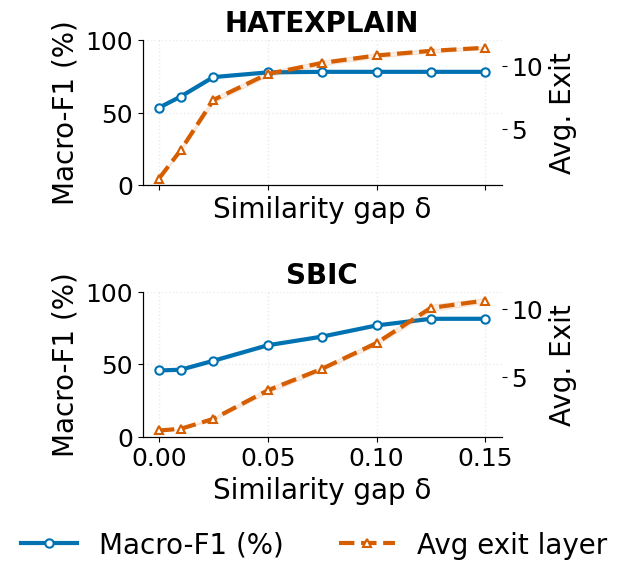

In [ ]:
import matplotlib.pyplot as plt

CBLUE   = "#0072B2" 
CORANGE = "#D55E00" 

plt.rcParams.update({
    "figure.figsize": (6, 6), 
    "axes.labelweight": "normal",
    "axes.titleweight": "bold",
    "font.sans-serif": ["DejaVu Sans", "Arial", "Liberation Sans", "Noto Sans"],
    "savefig.dpi": 200,
})

def _collect_series(agg_for_ds, gaps):
    gaps_sorted = sorted([g for g in gaps if g in agg_for_ds])
    f1_mean   = [agg_for_ds[g]["mean"]["f1m"] * 100.0 for g in gaps_sorted]  # %
    f1_std    = [agg_for_ds[g]["std"]["f1m"]  * 100.0 for g in gaps_sorted]
    exit_mean = [agg_for_ds[g]["mean"]["avg_exit"] for g in gaps_sorted]
    exit_std  = [agg_for_ds[g]["std"]["avg_exit"]  for g in gaps_sorted]
    return gaps_sorted, f1_mean, f1_std, exit_mean, exit_std

def _style_axes(ax):
    ax.grid(True, alpha=0.25, linestyle=":", linewidth=1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def plot_two_tradeoffs_vertical(ds_keys=("hatexplain", "sbic"),
                                titles=("HateXplain", "SBIC"),
                                savepath="threshold_tradeoff_vertical.pdf"):
    """Plots vertically stacked panels with shared legend beneath."""
    fig, axs = plt.subplots(len(ds_keys), 1, sharex=True, sharey=False, constrained_layout=True)
    if len(ds_keys) == 1:
        axs = [axs]

    all_lines, all_labels = [], []

    for ax, ds_key, title in zip(axs, ds_keys, titles):
        ds_agg = aggs[ds_key]
        gaps_sorted, f1_m, f1_s, ex_m, ex_s = _collect_series(ds_agg, GAP_VALUES)

        ln1 = ax.plot(
            gaps_sorted, f1_m, marker="o", markersize=6,
            markerfacecolor="white", markeredgewidth=1.5,
            linewidth=3, label="Macro-F1 (%)", color=CBLUE
        )
        ax.fill_between(gaps_sorted,
                        [m - s for m, s in zip(f1_m, f1_s)],
                        [m + s for m, s in zip(f1_m, f1_s)],
                        alpha=0.10, color=CBLUE)

        ax.set_xlabel("Similarity gap δ")
        ax.set_ylabel("Macro-F1 (%)")
        ax.set_title(title.upper())
        ax.set_ylim(0, 100)
        _style_axes(ax)

        ax2 = ax.twinx()
        ln2 = ax2.plot(
            gaps_sorted, ex_m, marker="^", markersize=6,
            markerfacecolor="white", markeredgewidth=1.5,
            linestyle="--", linewidth=3, label="Avg exit layer", color=CORANGE
        )
        ax2.fill_between(gaps_sorted,
                         [m - s for m, s in zip(ex_m, ex_s)],
                         [m + s for m, s in zip(ex_m, ex_s)],
                         alpha=0.10, color=CORANGE)
        ax2.set_ylabel("Avg. Exit")

        lines = ln1 + ln2
        labels = [l.get_label() for l in lines]
        all_lines.extend(lines)
        all_labels.extend(labels)

    unique = dict(zip(all_labels, all_lines))
    fig.legend(unique.values(), unique.keys(),
               loc="lower center", ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.02))

    fig.tight_layout(rect=[0, 0.05, 1, 1]) 
    fig.savefig(savepath, bbox_inches="tight")
    plt.show()

plot_two_tradeoffs_vertical()


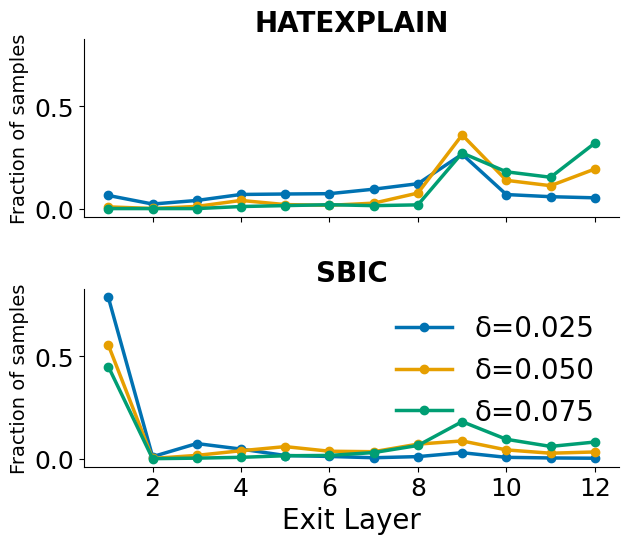

In [ ]:
def plot_exit_distributions_vertical(datasets, aggs, gaps):
    """Plot layer-wise exit distributions for multiple datasets (stacked vertically)."""

    COLORBLIND_PALETTE = ["#0072B2", "#E69F00", "#009E73"]  # blue, orange, green

    fig, axes = plt.subplots(len(datasets), 1, figsize=(7, 6), sharex=True, sharey=True)

    for i, dataset in enumerate(datasets):
        ax = axes[i]
        agg = aggs[dataset]
        for j, g in enumerate(gaps):
            if g not in agg:
                print(f"Warning: gap {g} not found in results for {dataset}")
                continue
            hist = agg[g]["mean"]["exit_hist"]
            frac = hist / hist.sum()
            ax.plot(
                np.arange(1, len(hist) + 1),
                frac,
                marker="o",
                label=f"δ={g:.3f}",
                linewidth=2.5,
                color=COLORBLIND_PALETTE[j % len(COLORBLIND_PALETTE)],
            )

        ax.set_ylabel("Fraction of samples", size=14)
        ax.set_title(dataset.upper())
        ax.legend().set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax.legend(frameon=False, loc="upper right", ncol = 1)
    axes[-1].set_xlabel("Exit Layer")
    plt.tight_layout()
    plt.savefig("layer_wise_exiting_opt_hx_sbic_vertical.pdf", bbox_inches="tight", dpi=300)
    plt.show()

plot_exit_distributions_vertical(
    datasets=["hatexplain", "sbic"],
    aggs=aggs,
    gaps=[0.025, 0.05, 0.075]
)


## Prototype-based Early Exit for BERT (cls token)

In [ ]:
# import os, random, numpy as np, pandas as pd, torch
# from typing import List, Tuple, Dict
# from sklearn.metrics import f1_score, accuracy_score
# from transformers import AutoTokenizer, AutoModel

MAX_SAMPLES_PER_CLASS_FOR_PROTOS = 500
BATCH_SIZE  = 8
MAX_LENGTH  = 500
USE_FP16    = False

TEXT_COL  = "sentence"
LABEL_COL = "label"

SAVE_PROTO_DIR = "saved_prototypes"  
os.makedirs(SAVE_PROTO_DIR, exist_ok=True)

def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def normalize_labels(series: pd.Series) -> pd.Series:
    mapping = {"hate":1, "non-hate":0, "nonhate":0, "non_hate":0, "neutral":0}
    def _to_int(x):
        if isinstance(x, str):
            xl = x.strip().lower()
            if xl in mapping: return mapping[xl]
            try: return int(x)
            except: raise ValueError(f"Unrecognized label: {x}")
        if isinstance(x, (int, np.integer)):
            if x in (0,1): return int(x)
        raise ValueError(f"Unsupported label value: {x}")
    return series.apply(_to_int)

class TextDS(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tok, max_len):
        self.texts, self.labels, self.tok, self.max_len = texts, labels, tok, max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        enc = self.tok(
            str(self.texts[i]), truncation=True, padding="max_length",
            max_length=self.max_len, return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[i]).long()
        return item

def make_loader(texts, labels, tok, max_len, bs, shuffle=False):
    return torch.utils.data.DataLoader(TextDS(texts, labels, tok, max_len), batch_size=bs, shuffle=shuffle)

@torch.no_grad()
def collect_layerwise_cls(model, loader, device) -> Tuple[List[np.ndarray], List[int]]:
    model.eval()
    feats_per_layer = None
    all_labels = []
    for batch in loader:
        ids = batch["input_ids"].to(device)
        att = batch["attention_mask"].to(device)
        all_labels.extend(batch["labels"].tolist())
        out = model(input_ids=ids, attention_mask=att, output_hidden_states=True)
        hs = out.hidden_states[1:] # skip embeddings
        cls_layers = [h[:, 0, :].detach() for h in hs]
        cls_np = [t.float().cpu().numpy() for t in cls_layers]
        if feats_per_layer is None: feats_per_layer = [[] for _ in range(len(cls_np))]
        for li, arr in enumerate(cls_np): feats_per_layer[li].append(arr)
    feats_per_layer = [np.concatenate(chunks, axis=0) for chunks in feats_per_layer]
    return feats_per_layer, all_labels

def l2_normalize(x: np.ndarray, axis: int = -1, eps: float = 1e-8) -> np.ndarray:
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / (n + eps)

def build_class_means(feats_per_layer: List[np.ndarray], labels: List[int]) -> Dict[int, List[np.ndarray]]:
    y = np.array(labels)
    class_means = {}
    for c in (0,1):
        idx = (y == c)
        means = []
        for feats in feats_per_layer:
            mu = feats[idx].mean(axis=0)
            mu = l2_normalize(mu[None, :], axis=1)[0]
            means.append(mu)
        class_means[c] = means
    return class_means

def save_class_means(dataset: str, seed: int, class_means: Dict[int, List[np.ndarray]]):
    save_path = os.path.join(SAVE_PROTO_DIR, f"{dataset}_seed{seed}_prototypes.npz")
    np.savez(save_path, **{
        f"class{c}_layer{li}": arr
        for c, layers in class_means.items()
        for li, arr in enumerate(layers)
    })
    print(f"[Saved] prototypes -> {save_path}")

def cosine_scores(x: np.ndarray, p0: np.ndarray, p1: np.ndarray):
    s0 = (x @ p0); s1 = (x @ p1)
    scores = np.stack([s0, s1], axis=1)
    conf = scores.max(axis=1)
    pred = scores.argmax(axis=1)
    gap  = np.sort(scores, axis=1)[:, -1] - np.sort(scores, axis=1)[:, -2]
    return conf, pred, gap

def early_exit_predict(test_feats_per_layer, class_means, threshold, min_gap):
    L = len(test_feats_per_layer)
    N = test_feats_per_layer[0].shape[0]
    preds = np.zeros(N, dtype=int)
    exit_layers = np.full(N, L-1)
    decided = np.zeros(N, bool)
    feats_norm = [l2_normalize(f) for f in test_feats_per_layer]
    for li in range(L):
        f = feats_norm[li]
        p0, p1 = class_means[0][li], class_means[1][li]
        conf, pred, gap = cosine_scores(f, p0, p1)
        to_exit = (~decided) & (gap >= min_gap)
        preds[to_exit] = pred[to_exit]
        exit_layers[to_exit] = li
        decided[to_exit] = True
    rem = ~decided
    if rem.any():
        f = feats_norm[-1]; p0, p1 = class_means[0][-1], class_means[1][-1]
        _, pred, _ = cosine_scores(f, p0, p1)
        preds[rem] = pred[rem]
    return preds, exit_layers

def compute_metrics(y_true, preds, exit_layers, num_layers):
    acc = accuracy_score(y_true, preds)
    f1m = f1_score(y_true, preds, average="macro")
    avg_exit = exit_layers.mean() + 1
    Nm = np.array([(exit_layers == m).sum() for m in range(num_layers)])
    full_cost = num_layers * Nm.sum()
    actual_cost = sum((m+1) * Nm[m] for m in range(num_layers))
    speedup = full_cost / actual_cost if actual_cost > 0 else 1.0
    early_mask = (exit_layers < (num_layers-1))
    coverage = early_mask.mean()
    early_prec = (preds[early_mask] == y_true[early_mask]).mean() if early_mask.any() else np.nan
    return {"acc":acc, "f1m":f1m, "avg_exit":avg_exit,
            "speedup":speedup, "coverage":coverage, "early_prec":early_prec,
            "exit_hist":Nm}

def run_dataset(dataset, seeds, gap_values):
    results = {g: [] for g in gap_values}
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_df = pd.read_csv(f"{dataset}_train.csv")
    test_df  = pd.read_csv(f"{dataset}_test.csv")
    for df in [train_df, test_df]:
        df.dropna(subset=[TEXT_COL, LABEL_COL], inplace=True)
        df["label"] = normalize_labels(df[LABEL_COL])
        df["text"]  = df[TEXT_COL].astype(str)

    for seed in seeds:
        set_seed(seed)
        MODEL_NAME = f"iproskurina/bert-base-cased-{dataset}-s{seed}"
        tok = AutoTokenizer.from_pretrained(MODEL_NAME)
        model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)
        if USE_FP16 and device.type == "cuda":
            model = model.half()
        model.to(device)

        tr0 = train_df[train_df["label"] == 0].head(MAX_SAMPLES_PER_CLASS_FOR_PROTOS)
        tr1 = train_df[train_df["label"] == 1].head(MAX_SAMPLES_PER_CLASS_FOR_PROTOS)
        protos = pd.concat([tr0, tr1])

        proto_loader = make_loader(protos["text"].tolist(), protos["label"].tolist(), tok, MAX_LENGTH, BATCH_SIZE)
        test_loader  = make_loader(test_df["text"].tolist(),  test_df["label"].tolist(),  tok, MAX_LENGTH, BATCH_SIZE)

        proto_feats, proto_labels = collect_layerwise_cls(model, proto_loader, device)
        class_means = build_class_means(proto_feats, proto_labels)
        save_class_means(dataset, seed, class_means)   # <-- save here

        test_feats, test_labels = collect_layerwise_cls(model, test_loader, device)
        y_true = np.array(test_labels)
        num_layers = len(test_feats)

        for g in gap_values:
            preds, exit_layers = early_exit_predict(test_feats, class_means, FIXED_THRESHOLD, g)
            m = compute_metrics(y_true, preds, exit_layers, num_layers)
            results[g].append(m)

        del model; torch.cuda.empty_cache()

    agg = {}
    for g in gap_values:
        metrics = results[g]
        agg[g] = {
            "mean": {k: np.nanmean([m[k] for m in metrics], axis=0) for k in metrics[0].keys()},
            "std":  {k: np.nanstd([m[k] for m in metrics], axis=0) for k in metrics[0].keys()},
        }
    return agg


def print_results_table(dataset, agg, gap_values):
    print(f"\n=== {dataset} averaged across seeds ===")
    print("gap\tAcc±std\tF1±std\tSpeedup±std\tAvgExit±std\tCoverage±std\tEarlyPrec±std")
    for g in gap_values:
        a = agg[g]["mean"]
        s = agg[g]["std"]
        print(f"{g:.2f}\t"
              f"{a['acc']:.3f}±{s['acc']:.3f}\t"
              f"{a['f1m']:.3f}±{s['f1m']:.3f}\t"
              f"{a['speedup']:.2f}±{s['speedup']:.2f}\t"
              f"{a['avg_exit']:.2f}±{s['avg_exit']:.2f}\t"
              f"{a['coverage']:.2f}±{s['coverage']:.2f}\t"
              f"{a['early_prec']:.2f}±{s['early_prec']:.2f}")

GAP_VALUES = [0, 0.01, 0.025, 0.05]
datasets = ["hatexplain","olid","ihc","sbic"]
seeds = list(range(10))
aggs = dict()
for dataset in datasets:
    agg = run_dataset(dataset, seeds, GAP_VALUES)
    print_results_table(dataset, agg, GAP_VALUES)
    aggs[dataset] = agg